## IMAGE CLASSIFICATION USING CNN (Tensorflow and keras)

Import the libraries

In [1]:
pip install tensorflow_datasets


Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
from skimage import color
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd


import os
import cv2
import numpy as np

import glob
import PIL

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow import keras
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds


C:\Users\User\anaconda3\envs\gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load the dataset

In [3]:
tfds.list_builders() #to see the available datasets

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'answer_equivalence',
 'arc',
 'asqa',
 'asset',
 'assin2',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'bee_dataset',
 'beir',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'ble_wind_field',
 'blimp',
 'booksum',
 'bool_q',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cardiotox',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'cherry_blossoms',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'coqa',
 'cos_e',
 'cosmos_qa',
 'covid19',
 'covid19sum',
 'crema_d',
 'criteo',
 'cs_restaurants',
 'cura

In [4]:
dataset= tfds.builder("mnist")
information=dataset.info


Our desired dataset contains images of dimension (28,28,1) and 10 different classes. 

Preparing the data

In [5]:
data_train= tfds.load(name="mnist", split="train")
data_test=tfds.load(name="mnist", split="test")

The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


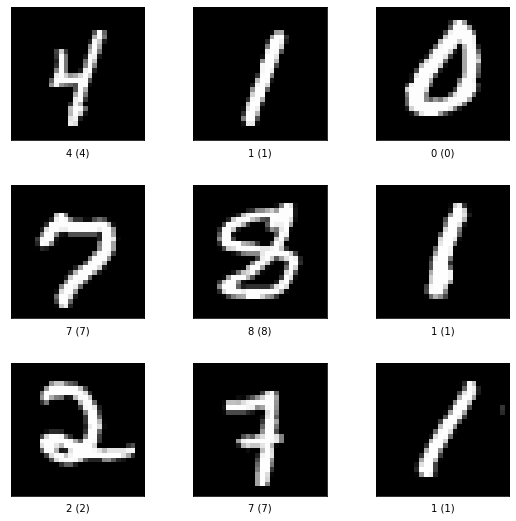

In [6]:
fig= tfds.show_examples(information, data_train)

In [7]:
train_images = np.array([example['image'].numpy() for example in data_train])
train_labels = np.array([example['label'].numpy() for example in data_train])

test_images = np.array([example['image'].numpy() for example in data_test])
test_labels = np.array([example['label'].numpy() for example in data_test])

In [8]:
# lets visualize the dimension of each loaded dataset
print("MNIST")
print("Dimensions del conjunt de dades d'entrenament: {}".format(train_images.shape))
print("Dimensions del conjunt d'etiquetes d'entrenament: {}".format(test_images.shape))
print("Dimensions del conjunt de dades de test: {}".format(train_labels.shape))
print("Dimensions del conjunt d'etiquetes de test: {}".format(test_labels.shape))


MNIST
Dimensions del conjunt de dades d'entrenament: (60000, 28, 28, 1)
Dimensions del conjunt d'etiquetes d'entrenament: (10000, 28, 28, 1)
Dimensions del conjunt de dades de test: (60000,)
Dimensions del conjunt d'etiquetes de test: (10000,)


We have our data splitted into train and test set. We have 60000 training images and 10000 testing images. 

Let's normalize our images: 

In [9]:
train_images = train_images.astype('float32') / 255
test_images=test_images.astype('float32') / 255

### Neural architecture search: 

We will be using KerasTuner to optimize the hyperparameters of our neural net. We will also use data augmentation to reduce the overfitting of our model. To reduce calculation time, we will set 10 as the number of epochs and it will only calculate 20 different architectures (max_trials).

In [10]:
import keras_tuner

In [11]:
from kerastuner.tuners import RandomSearch
import keras_tuner


data_augmentation = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomRotation(0.1),
    keras.layers.experimental.preprocessing.RandomZoom(0.1),


])

def build_model(hp):
    model=keras.Sequential([data_augmentation])

    for i in range(hp.Int("Conv Layers", min_value=1, max_value=2)):
        model.add(keras.layers.Conv2D(hp.Choice(f"layer_{i}_filters",[8, 16, 32]),2,activation="relu"))

    model.add(keras.layers.MaxPool2D(2,2))
    model.add(keras.layers.Dropout(0.5))


    model.add(keras.layers.Flatten())
    
    for i in range(hp.Int("Dense layers", min_value=0, max_value=4)):
        model.add(keras.layers.Dense(hp.Choice(f"Dense layer_{i}", [32, 64, 128, 256, 512,]), activation='relu'))  
        model.add(keras.layers.Dropout(0.5))

    #last layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    model.compile(optimizer="adam",
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])
  
    return model


tuner=RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=30
    
)

tuner.search(train_images, train_labels, validation_split=0.1, epochs=10, batch_size=32 )


Trial 30 Complete [00h 00m 36s]
val_accuracy: 0.9826666712760925

Best val_accuracy So Far: 0.987333357334137
Total elapsed time: 00h 06m 01s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


After our training we can observe the architecture of the neural net that best performed: 

In [12]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

model = tuner.hypermodel.build(best_hps)

Let's train the model with the best architecture found in the previous step: 

In [13]:
history = model.fit(train_images, train_labels, epochs=100, validation_data=(test_images,test_labels))


Epoch 1/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4466 - accuracy: 0.8552 - val_loss: 0.1212 - val_accuracy: 0.9640
Epoch 2/100
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2354 - accuracy: 0.9265 - val_loss: 0.0871 - val_accuracy: 0.9746
Epoch 3/100
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2060 - accuracy: 0.9367 - val_loss: 0.0762 - val_accuracy: 0.9769
Epoch 4/100
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1830 - accuracy: 0.9441 - val_loss: 0.0660 - val_accuracy: 0.9798
Epoch 5/100
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1674 - accuracy: 0.9494 - val_loss: 0.0548 - val_accuracy: 0.9828
Epoch 6/100
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1638 - accuracy: 0.9514 - val_loss: 0.0555 - val_accuracy: 0.9827
Epoch 7/100
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1543 - accuracy: 0.9530 - val_loss: 0.0540 - val_ac

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 16)        80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 13, 13, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2704)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1384960   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

We can observe some performance plots: 

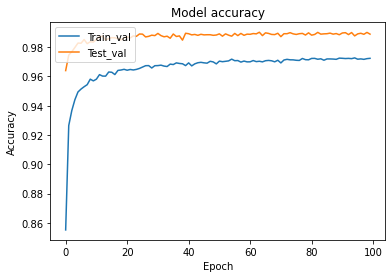

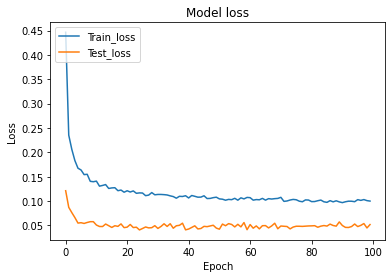

In [15]:
def accuracy_plot(history):
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("Model accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train_val", "Test_val"], loc="upper left")
    plt.show()

def loss_plot(history):
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Model loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train_loss", "Test_loss"], loc="upper left")
    plt.show()
    
    
accuracy_plot(history)
loss_plot(history)

In [16]:
print("The validation accuracy of our final model is: ", history.history["val_accuracy"][-1])

The validation accuracy of our final model is:  0.9889000058174133
